In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob
import pdb
%matplotlib inline

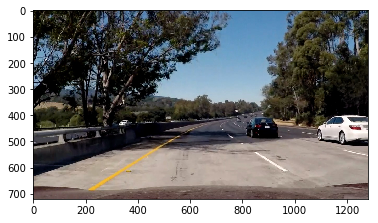

In [2]:
image = cv2.imread("./test_images/test5.jpg")
plt.imshow(image[:,:,::-1])

In [3]:
# undistort image

In [4]:
# def calibrateCamera(chessboard_image_dir, (nx, ny)):
chessboard_image_paths = glob.glob("./camera_cal/calibration*.jpg")

nx, ny = 9, 6
image_points = []
object_points = []
mapped_corners = np.zeros([nx * ny, 3], np.float32)
mapped_corners[:,:2] = np.mgrid[:nx, :ny].T.reshape([-1, 2])

for chessboard_image_path in chessboard_image_paths:
    chessboard_image = cv2.imread(chessboard_image_path)
    gray_chessboard_image = cv2.cvtColor(chessboard_image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray_chessboard_image, (nx, ny), None)
    if ret:
        object_points.append(mapped_corners)
        image_points.append(corners)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, chessboard_image.shape[1::-1], None, None)
# return mtx, dist

In [5]:
def calibrateCamera(chessboard_image_paths, nx, ny):
    image_points = []
    object_points = []
    mapped_corners = np.zeros([nx * ny, 3], np.float32)
    mapped_corners[:,:2] = np.mgrid[:nx, :ny].T.reshape([-1, 2])

    for chessboard_image_path in chessboard_image_paths:
        chessboard_image = cv2.imread(chessboard_image_path)
        gray_chessboard_image = cv2.cvtColor(chessboard_image, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray_chessboard_image, (nx, ny), None)
        if ret:
            object_points.append(mapped_corners)
            image_points.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, chessboard_image.shape[1::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs

In [6]:
chessboard_image_paths = glob.glob("./camera_cal/calibration*.jpg")
ret, mtx, dist, rvecs, tvecs = calibrateCamera(chessboard_image_paths, 9, 6)

In [7]:
# perspective transform

In [8]:
#src = np.float32([[300, 675], [1030, 675], [700, 456], [585, 456]])
#dst = np.float32([[300, 675], [1030, 675], [1030, 200], [300, 200]])
src = np.float32([[300, 675], [1030, 675], [700, 456], [585, 456]])
dst = np.float32([[300, 720], [1030, 720], [1030, 200], [300, 200]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

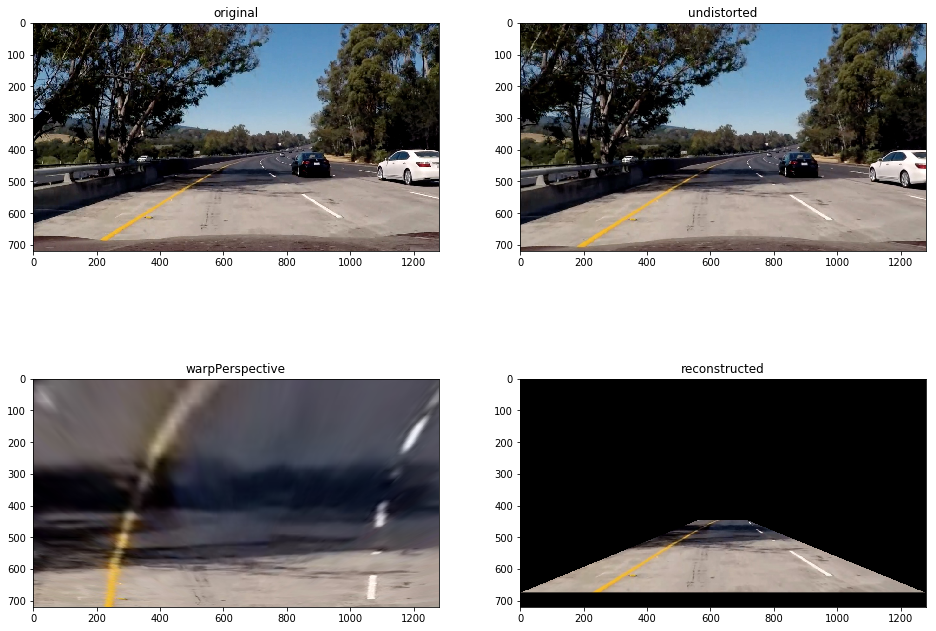

In [39]:
straight_line_image = cv2.imread("./test_images/test5.jpg")
straight_line_image = straight_line_image[:,:,::-1]
plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
plt.title("original")
cv2.imwrite("original.jpg", straight_line_image[:,:,::-1])
plt.imshow(straight_line_image)
undistorted = cv2.undistort(straight_line_image, mtx, dist, None, mtx)
cv2.imwrite('undistorted.jpg', undistorted[:,:,::-1])
plt.subplot(2, 2, 2)
plt.title("undistorted")
plt.imshow(undistorted)
birdeye = cv2.warpPerspective(undistorted, M, straight_line_image.shape[1::-1], cv2.INTER_CUBIC)
plt.subplot(2, 2, 3)
plt.title("warpPerspective")
plt.imshow(birdeye)
cv2.imwrite("warped.jpg", birdeye[:,:,::-1])
reconst = cv2.warpPerspective(birdeye, Minv, straight_line_image.shape[1::-1], cv2.INTER_CUBIC)
plt.subplot(2, 2, 4)
plt.title("reconstructed")
plt.imshow(reconst)

In [10]:
def thresh2Binary(inp, thresh_min, thresh_max):
    binary = np.zeros_like(inp)
    binary[(thresh_min <= inp) & (inp <= thresh_max)] = 1
    return binary

In [11]:
def scaledThresh2Binary(inp, thresh_min, thresh_max):
    scaled = np.uint8(inp / np.max(inp) * 255)
    return thresh2Binary(scaled, thresh_min, thresh_max)

In [12]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # thresh=(20, 100)
    if orient == 'x':
        sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        raise AugumentError
    return scaledThresh2Binary(sobel, thresh[0], thresh[1])

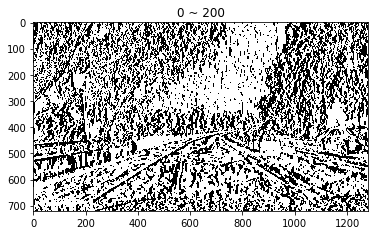

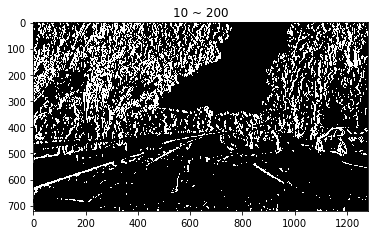

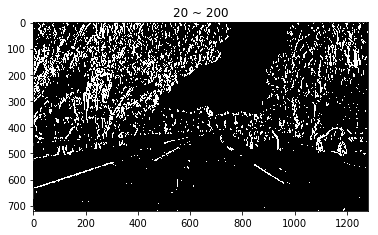

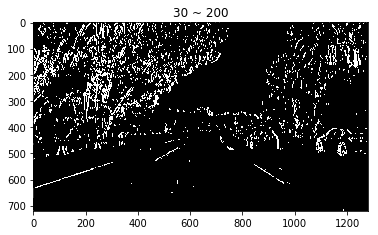

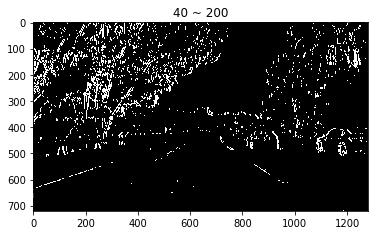

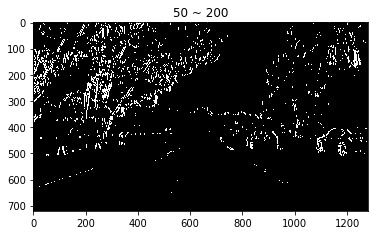

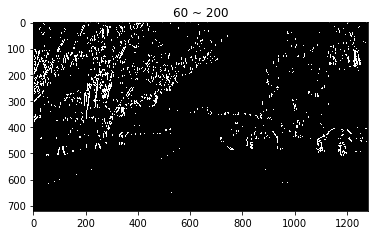

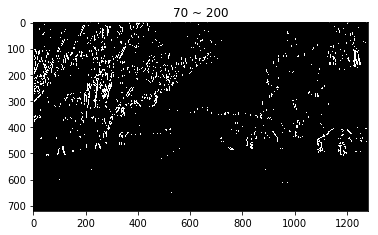

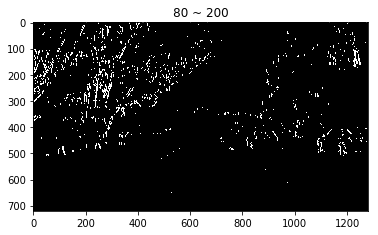

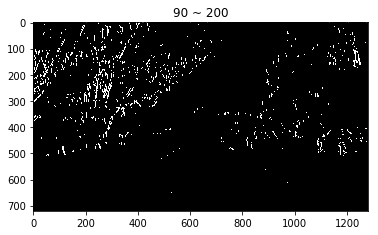

In [13]:
thresh_min = 0
thresh_max = 200
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
for i in range(10):
    plt.figure(i)
    plt.title("%d ~ %d" % (thresh_min, thresh_max))
    sobel = abs_sobel_thresh(gray, 'x', 15, (thresh_min, thresh_max))
    plt.imshow(sobel, cmap='gray')
    thresh_min += 10

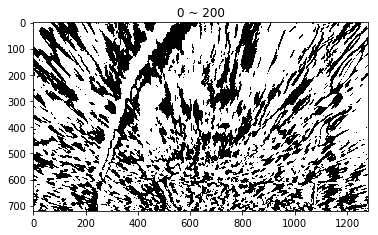

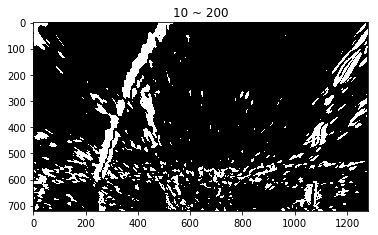

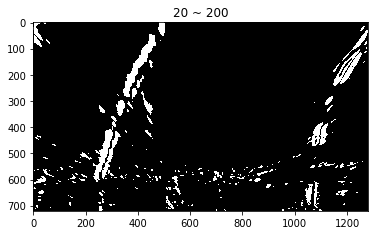

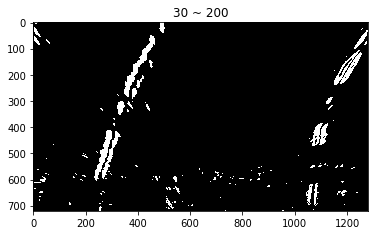

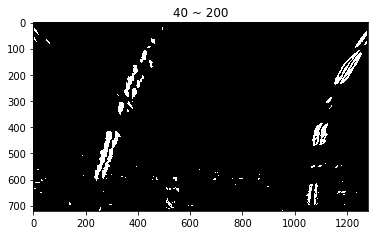

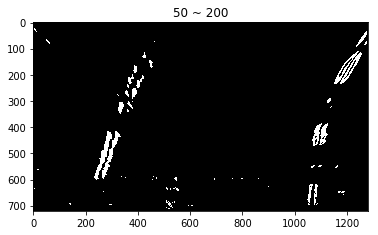

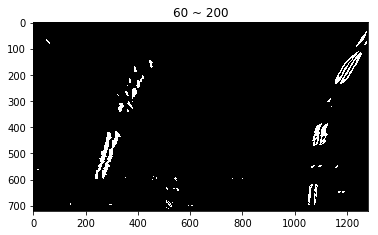

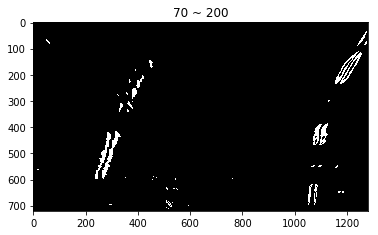

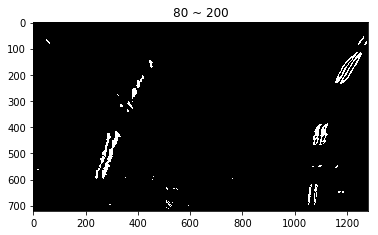

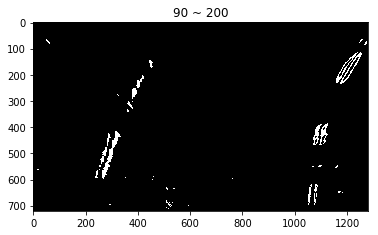

In [14]:
# 60 ~ 200
thresh_min = 0
thresh_max = 200
gray = cv2.cvtColor(birdeye, cv2.COLOR_BGR2GRAY)
for i in range(10):
    plt.figure(i)
    plt.title("%d ~ %d" % (thresh_min, thresh_max))
    sobel = abs_sobel_thresh(gray, 'x', 15, (thresh_min, thresh_max))
    plt.imshow(sobel, cmap='gray')
    thresh_min += 10

In [15]:
def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    # sobel_kernel=9, mag_thresh=(30, 100)
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    magnitude = np.sqrt(np.square(sobelx) + np.square(sobely))
    return scaledThresh2Binary(magnitude, thresh[0], thresh[1])

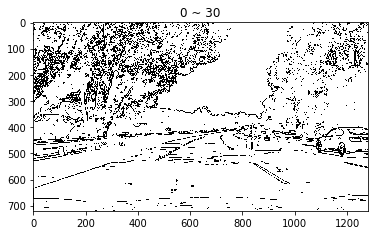

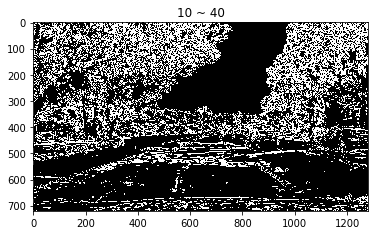

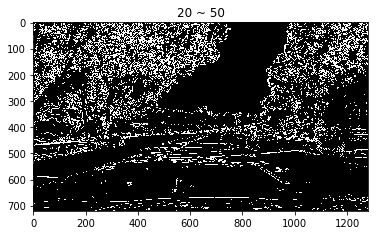

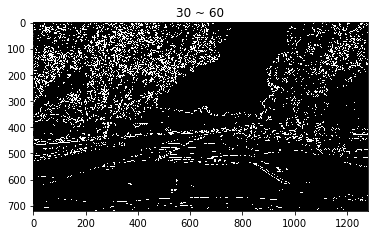

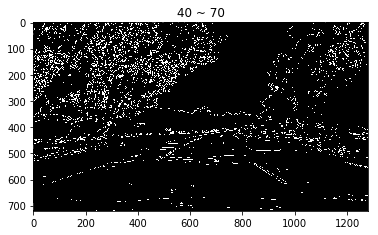

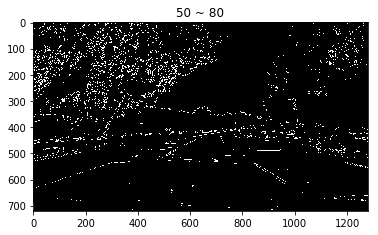

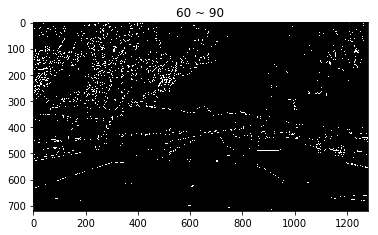

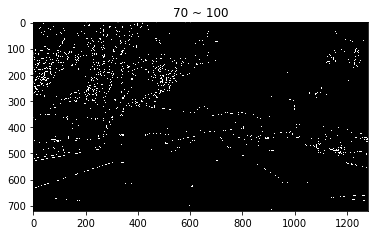

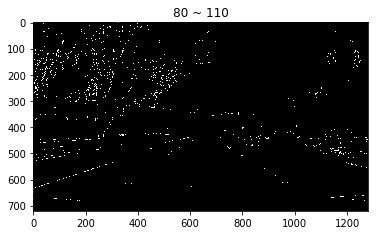

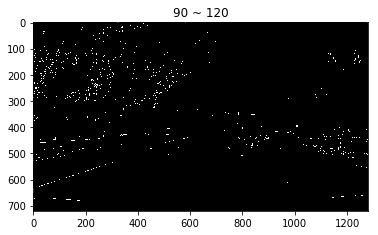

In [16]:
thresh_min = 0
thresh_max = 200
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
for i in range(10):
    plt.figure(i)
    plt.title("%d ~ %d" % (thresh_min, thresh_min+30))
    mag = mag_thresh(gray, 3, (thresh_min, thresh_min+30))
    plt.imshow(mag, cmap='gray')
    thresh_min += 10

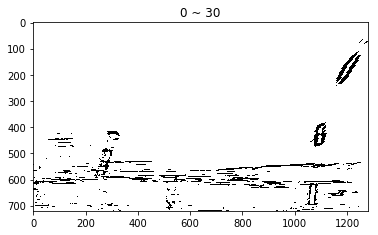

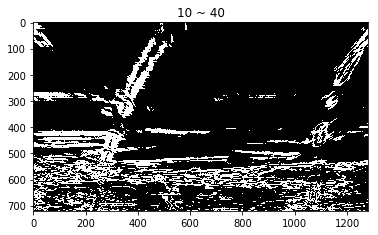

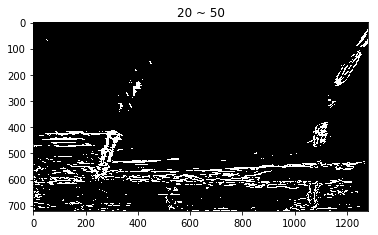

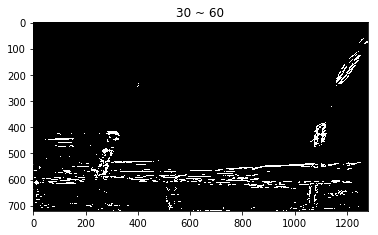

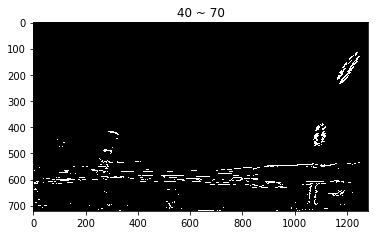

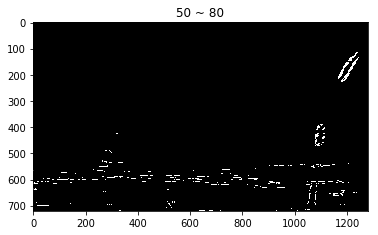

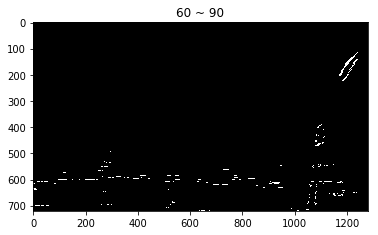

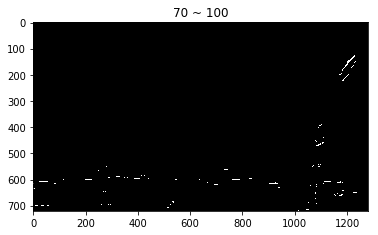

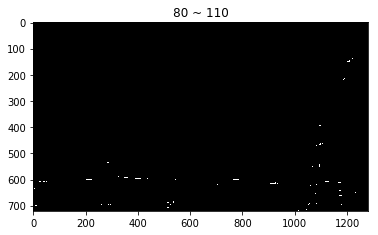

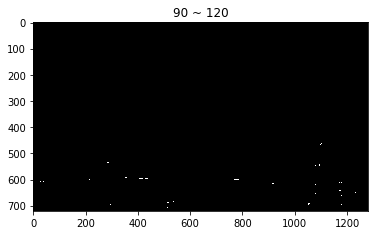

In [17]:
thresh_min = 0
thresh_max = 200
gray = cv2.cvtColor(birdeye, cv2.COLOR_BGR2GRAY)
for i in range(10):
    plt.figure(i)
    plt.title("%d ~ %d" % (thresh_min, thresh_min+30))
    mag = mag_thresh(gray, 3, (thresh_min, thresh_min+30))
    plt.imshow(mag, cmap='gray')
    thresh_min += 10

In [18]:
def dir_thresh(image, sobel_kernel=3, thresh=(0, np.pi/2)):
#def dir_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    # sobel_kernel=15, thresh=(0.7, 1.3)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    direction = np.arctan2(abs_sobely, abs_sobelx)
    
    #return scaledThresh2Binary(direction, thresh[0], thresh[1])
    return thresh2Binary(direction, thresh[0], thresh[1])

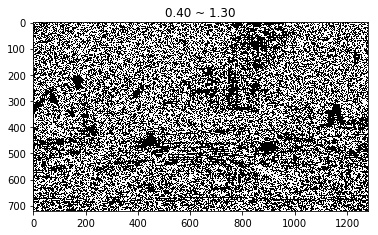

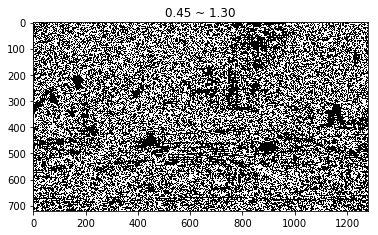

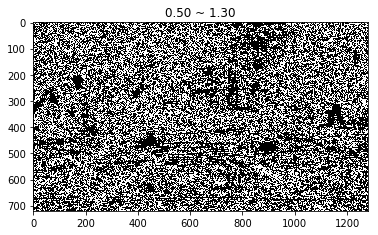

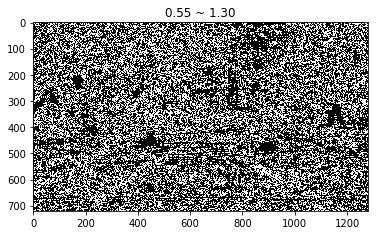

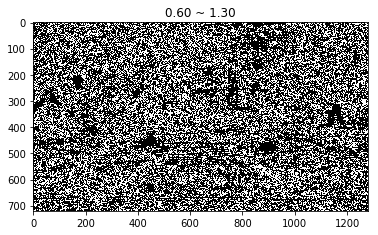

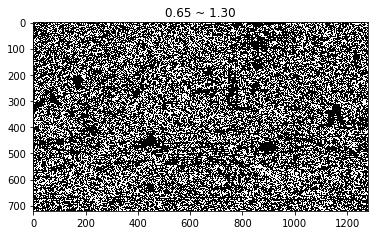

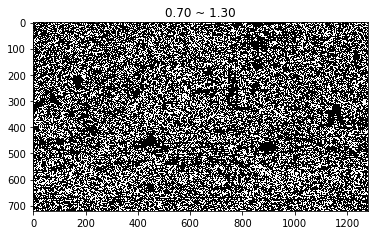

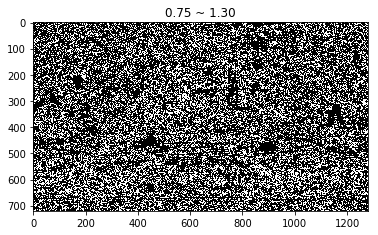

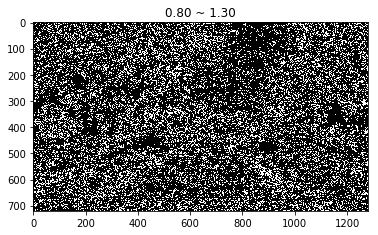

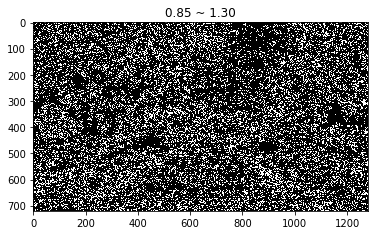

In [19]:
thresh_min = 0.4
thresh_max = 1.3
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
for i in range(10):
    plt.figure(i)
    plt.title("%.2f ~ %.2f" % (thresh_min, thresh_max))
    mag = dir_thresh(gray, 3, (thresh_min, thresh_max))
    plt.imshow(mag, cmap='gray')
    thresh_min += 0.05

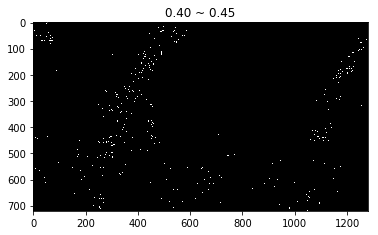

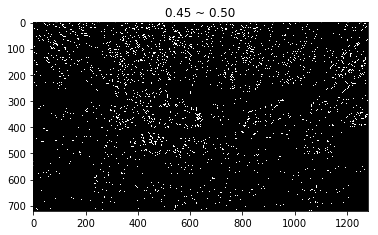

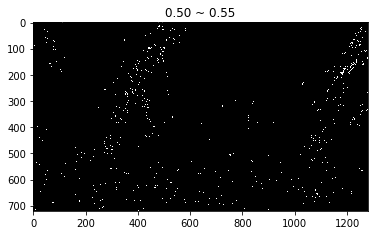

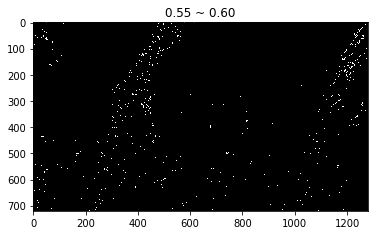

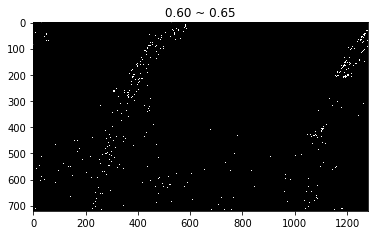

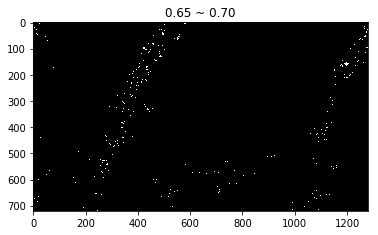

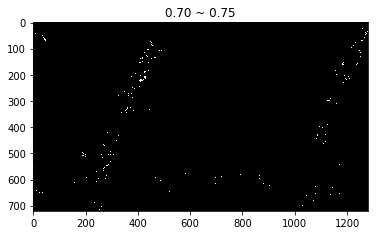

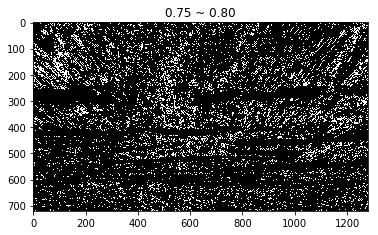

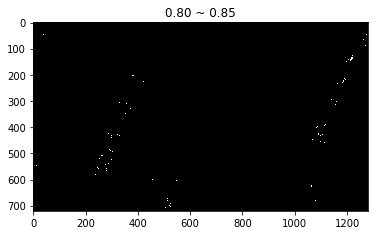

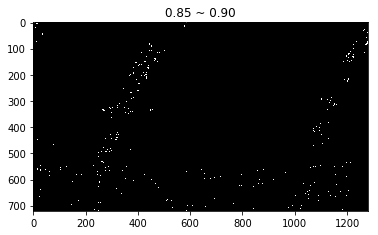

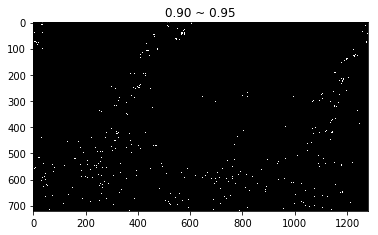

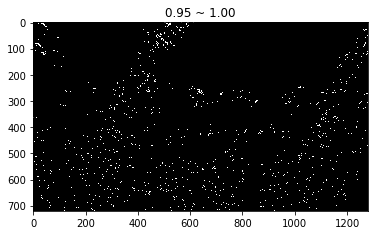

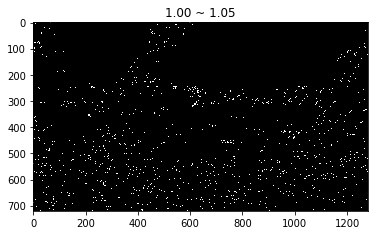

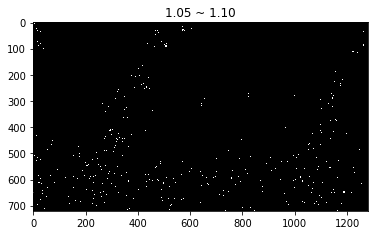

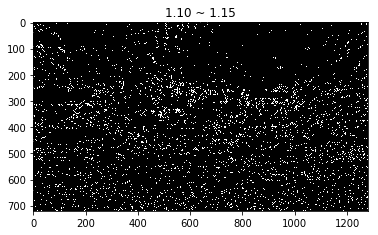

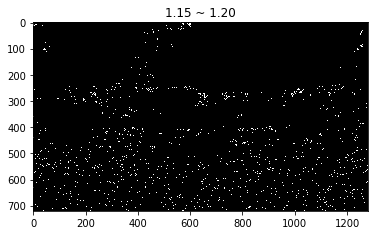

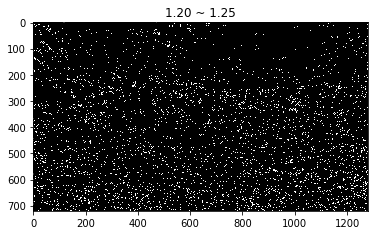

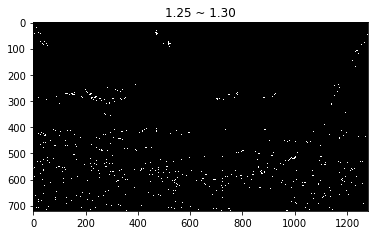

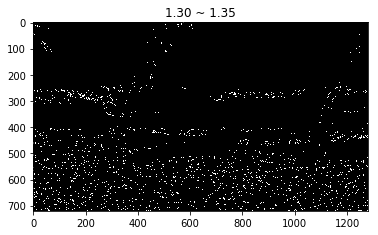

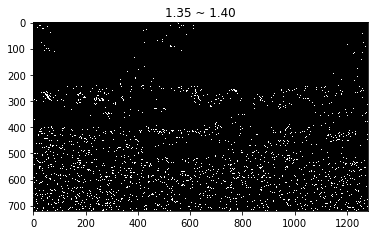

In [20]:
# 0.7~0.75
thresh_min = 0.4
thresh_max = 1.3
gray = cv2.cvtColor(birdeye, cv2.COLOR_BGR2GRAY)
for i in range(20):
    plt.figure(i)
    plt.title("%.2f ~ %.2f" % (thresh_min, thresh_min+0.05))
    mag = dir_thresh(gray, 3, (thresh_min, thresh_min+0.05))
    plt.imshow(mag, cmap='gray')
    thresh_min += 0.05

In [21]:
def hls_thresh(image, channel='h', thresh=(0, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    if channel == 'h':
        c = 0
    elif channel == 'l':
        c = 1
    elif channel == 's':
        c = 2
    else:
        raise ArgumentError
    return scaledThresh2Binary(hls[:,:,c], thresh[0], thresh[1])

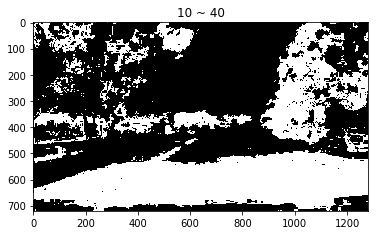

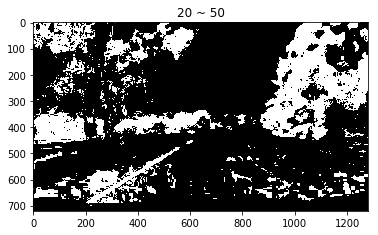

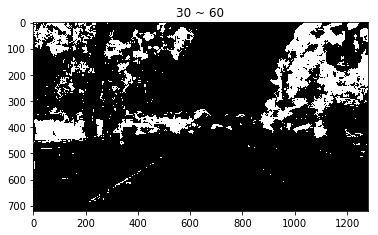

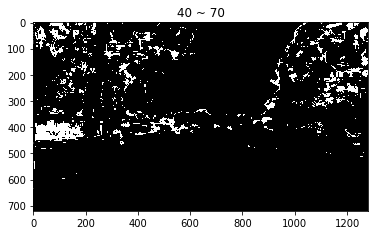

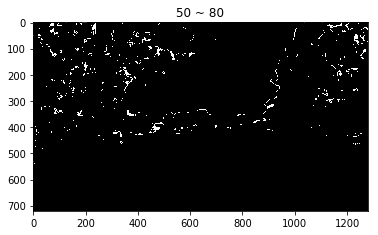

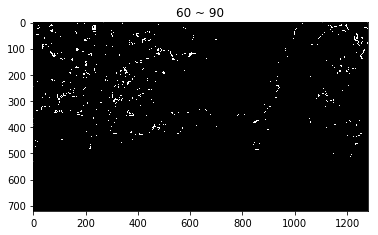

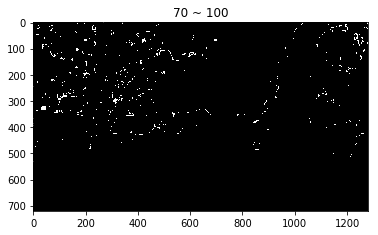

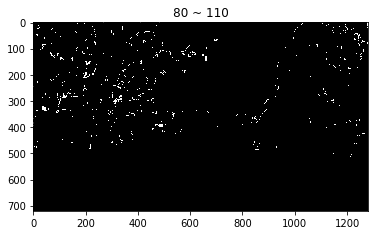

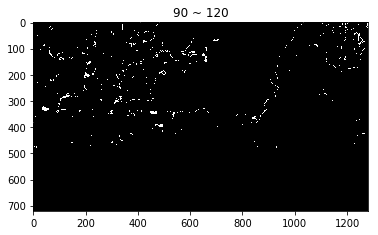

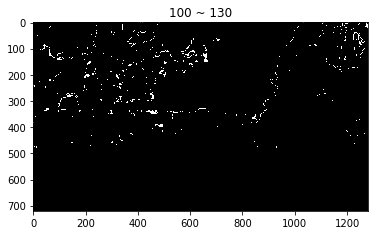

In [22]:
thresh_min = 10
thresh_max = 250
for i in range(10):
    plt.figure(i)
    plt.title("%d ~ %d" % (thresh_min, thresh_min+30))
    s = hls_thresh(image, 'h', (thresh_min, thresh_min+30))
    plt.imshow(s, cmap='gray')
    thresh_min += 10

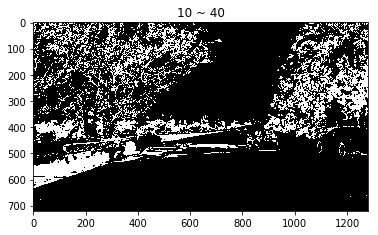

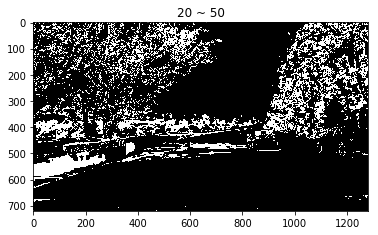

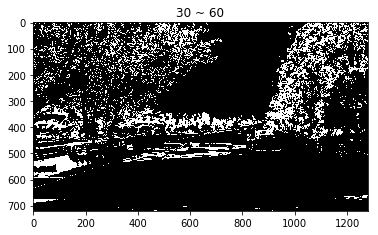

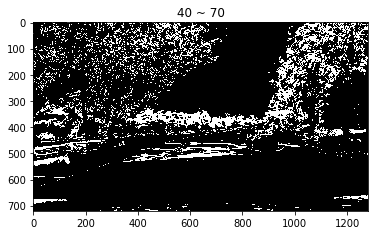

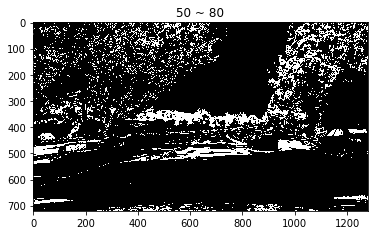

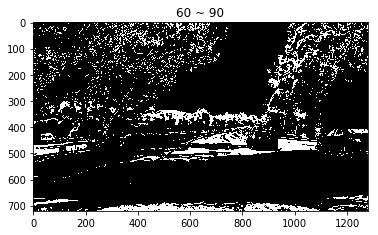

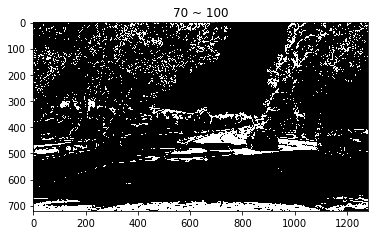

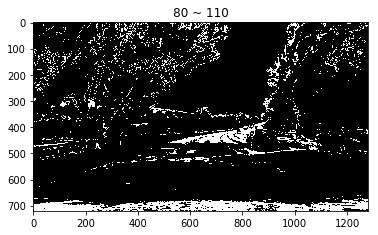

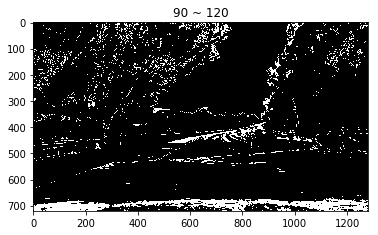

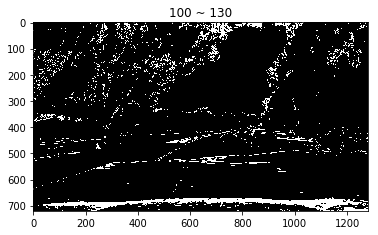

In [23]:
thresh_min = 10
thresh_max = 250
for i in range(10):
    plt.figure(i)
    plt.title("%d ~ %d" % (thresh_min, thresh_min+30))
    s = hls_thresh(image, 'l', (thresh_min, thresh_min+30))
    plt.imshow(s, cmap='gray')
    thresh_min += 10

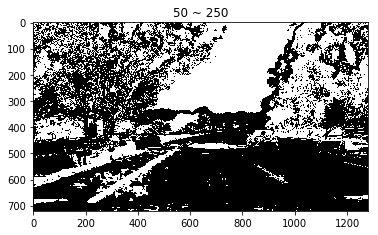

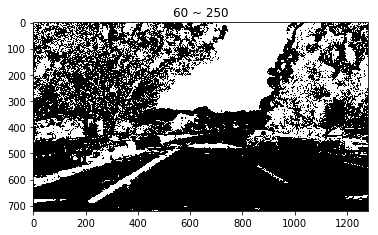

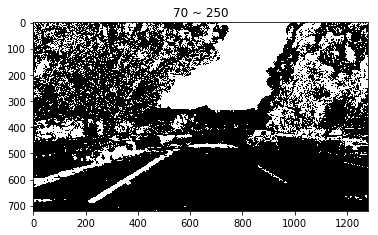

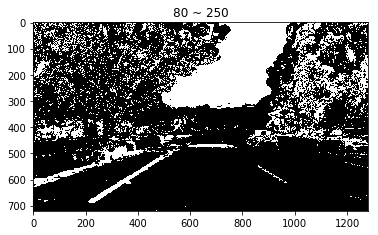

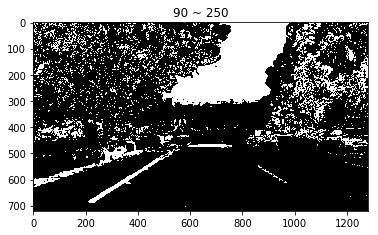

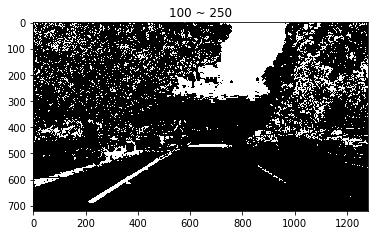

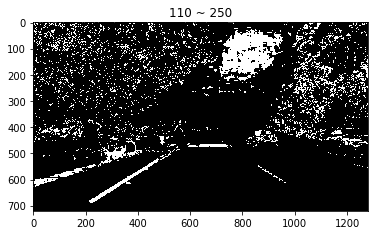

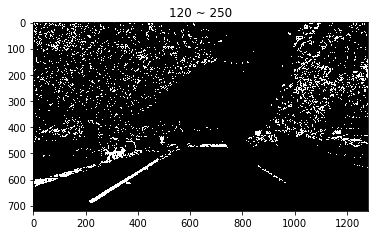

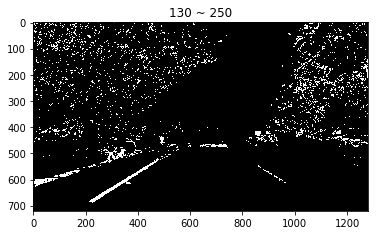

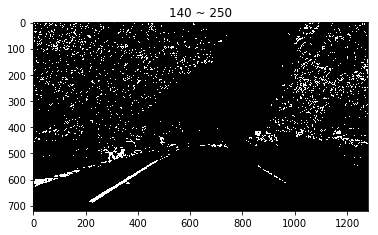

In [24]:
thresh_min = 50
thresh_max = 250
for i in range(10):
    plt.figure(i)
    plt.title("%d ~ %d" % (thresh_min, thresh_max))
    s = hls_thresh(image, 's', (thresh_min, thresh_max))
    plt.imshow(s, cmap='gray')
    thresh_min += 10

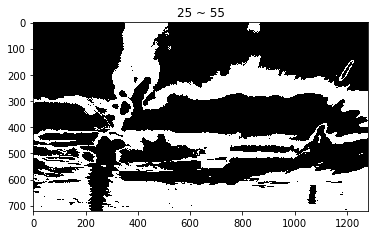

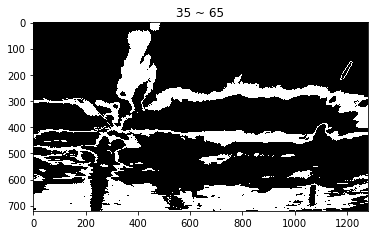

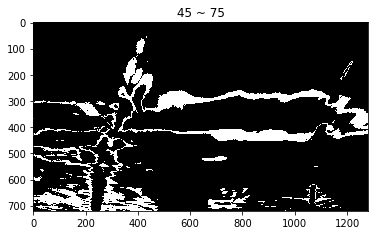

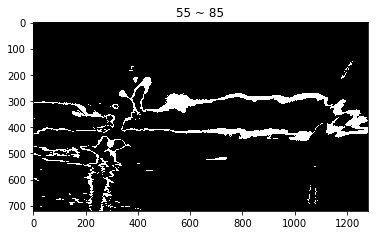

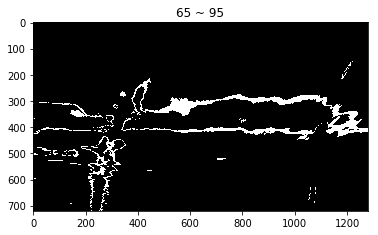

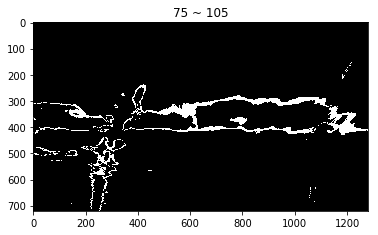

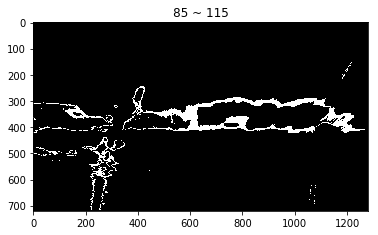

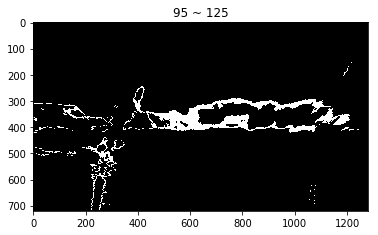

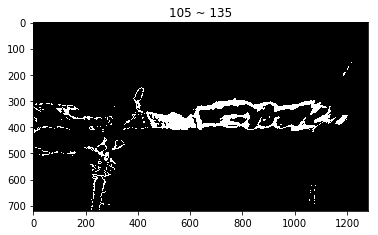

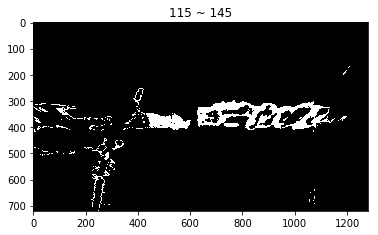

In [25]:
thresh_min = 25
thresh_max = 250
for i in range(10):
    plt.figure(i)
    plt.title("%d ~ %d" % (thresh_min, thresh_min+30))
    s = hls_thresh(birdeye, 's', (thresh_min, thresh_min+30))
    plt.imshow(s, cmap='gray')
    thresh_min += 10

In [26]:
def combineBinary(binaryImages = []):
    binary = np.zeros_like(binaryImages[0])
    for bImg in binaryImages:
        binary[bImg == 1] = 1
    return binary

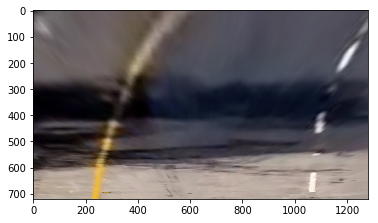

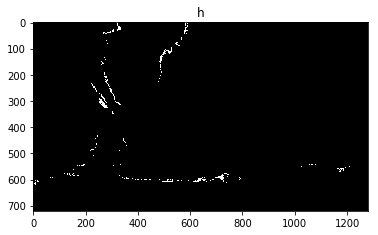

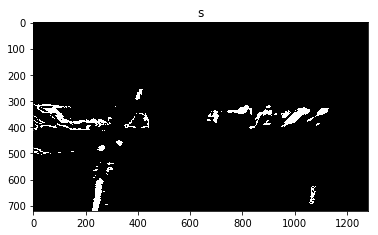

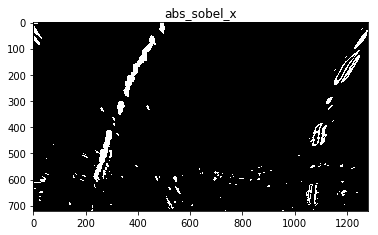

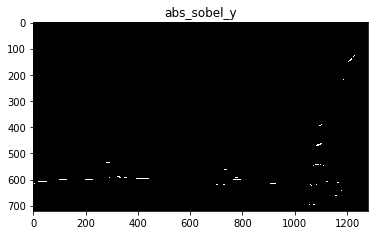

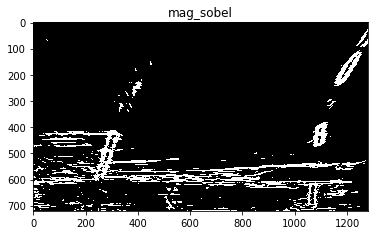

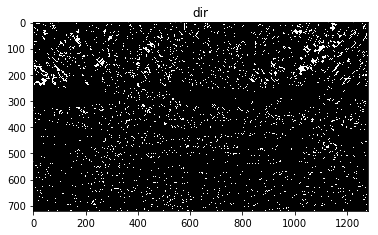

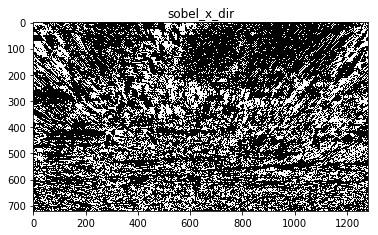

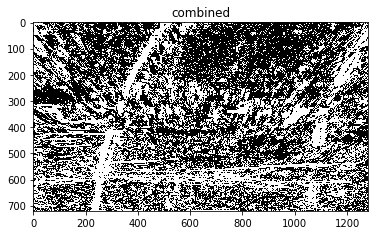

In [27]:
image = birdeye
binaryImages = []
i = 0
plt.figure(i)
plt.imshow(image)
i += 1
h = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,0]
h_binary = np.zeros_like(h)
h_binary[(np.pi / 6 <= h) & (h <= np.pi / 6 * 5)] = 1
plt.figure(i)
plt.title('h')
plt.imshow(h_binary, cmap='gray')
binaryImages.append(h_binary)
i += 1
# l_binary = hls_thresh(image, 'l', (150,255))
# plt.figure(i)
# plt.title('l')
# plt.imshow(l_binary, cmap='gray')
# binaryImages.append(l_binary)
i += 1
s_binary = hls_thresh(image, 's', (150,250))
plt.figure(i)
plt.title('s')
plt.imshow(s_binary, cmap='gray')
binaryImages.append(s_binary)
i += 1
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
sobel_x_binary = abs_sobel_thresh(gray, 'x', 15, (30, 150))
plt.figure(i)
plt.title('abs_sobel_x')
plt.imshow(sobel_x_binary, cmap='gray')
binaryImages.append(sobel_x_binary)
i += 1
sobel_y_binary = abs_sobel_thresh(gray, 'y', 15, (100, 150))
plt.figure(i)
plt.title('abs_sobel_y')
plt.imshow(sobel_y_binary, cmap='gray')
binaryImages.append(sobel_y_binary)
i += 1
mag_binary = mag_thresh(gray, 3, (20, 250))
plt.figure(i)
plt.title('mag_sobel')
plt.imshow(mag_binary, cmap='gray')
binaryImages.append(mag_binary)
i += 1
dir_binary = dir_thresh(gray, 15, (0.7, 0.8))
plt.figure(i)
plt.title('dir')
plt.imshow(dir_binary, cmap='gray')
binaryImages.append(dir_binary)
i += 1
sobel_x_dir_binary = dir_thresh(sobel_x_binary, 3, (0.7, 1.3))
plt.figure(i)
plt.title('sobel_x_dir')
plt.imshow(sobel_x_dir_binary, cmap='gray')
binaryImages.append(sobel_x_dir_binary)
i += 1
combined_binary = combineBinary(binaryImages)
plt.figure(i)
plt.title('combined')
plt.imshow(combined_binary, cmap='gray')
# color_binary = np.dstack(( np.zeros_like(sobel_binary), sobel_binary, s_binary)) * 255
# # Combine the two binary thresholds
# combined_binary = np.zeros_like(sobel_binary)
# combined_binary[(s_binary == 1) | (sobel_binary == 1)] = 1

# # Plotting thresholded images
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# ax1.set_title('Stacked thresholds')
# ax1.imshow(color_binary)

# ax2.set_title('Combined S channel and gradient thresholds')
# ax2.imshow(combined_binary, cmap='gray')

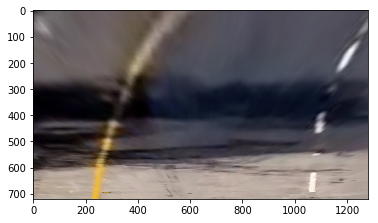

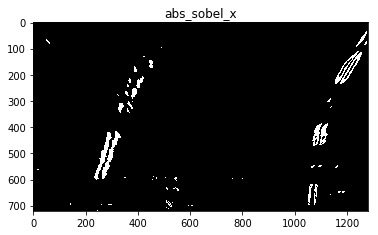

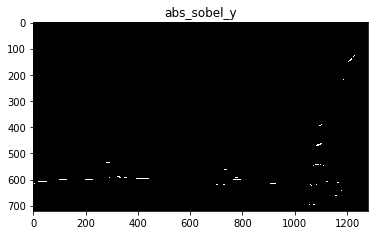

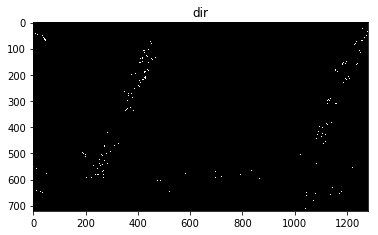

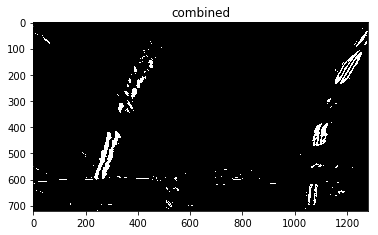

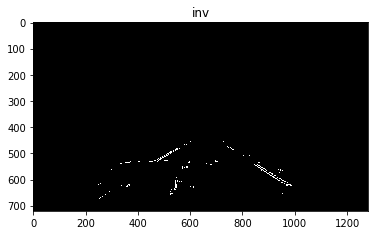

In [28]:
image = birdeye
binaryImages = []
i = 0
plt.figure(i)
plt.imshow(image)
i += 1
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
sobel_x_binary = abs_sobel_thresh(gray, 'x', 15, (60, 200))
plt.figure(i)
plt.title('abs_sobel_x')
plt.imshow(sobel_x_binary, cmap='gray')
binaryImages.append(sobel_x_binary)
i += 1
sobel_y_binary = abs_sobel_thresh(gray, 'y', 15, (100, 150))
plt.figure(i)
plt.title('abs_sobel_y')
plt.imshow(sobel_y_binary, cmap='gray')
binaryImages.append(sobel_y_binary)
i += 1
dir_binary = dir_thresh(gray, 3, (0.7, 0.75))
plt.figure(i)
plt.title('dir')
plt.imshow(dir_binary, cmap='gray')
binaryImages.append(dir_binary)
i += 1
combined_binary = combineBinary(binaryImages)
plt.figure(i)
plt.title('combined')
plt.imshow(combined_binary, cmap='gray')
i += 1
inv = cv2.warpPerspective(combined_binary, Minv, combined_binary.shape[::-1])
plt.figure(i)
plt.title('inv')
plt.imshow(inv, cmap='gray')

In [29]:
# hist

In [30]:
def bottomHistogram(img):
    bottom_half = img[img.shape[0]//2:, :]
    hist = np.sum(bottom_half, axis=0)
    return hist

In [31]:
def getTwoPeaks(histogram):
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return leftx_base, rightx_base

In [32]:
def getWindow(x_center, y_center, window_width=200, window_height=80):
    top = y_center - window_height / 2
    bottom = y_center + window_height / 2
    left = x_center - window_width / 2
    right = x_center + window_width / 2
    return top, bottom, left, right

In [33]:
def getLanePoints(canvas, nonzero_x, nonzero_y, x_center, window_height=80, window_width=200, n_recenter=50):
    lane_points = None
    
    y_center = canvas.shape[0] - window_height / 2
    top, bottom, left, right = getWindow(x_center, y_center, window_width, window_height)

    momentum = 0.0
    in_indexes = np.zeros_like(nonzero_x, dtype=np.bool)
    current_in_indexes = np.zeros_like(nonzero_x, dtype=np.bool)
    while y_center >= 0 and x_center >= 0 and x_center <= canvas.shape[1]:
        current_in_indexes |= ((left <= nonzero_x) & (nonzero_x <= right) & (top <= nonzero_y) & (nonzero_y <= bottom))
        if np.count_nonzero(current_in_indexes) >= n_recenter:
            new_x_center = nonzero_x[current_in_indexes].mean()
            momentum = new_x_center - x_center
            x_center = new_x_center
        else:
            x_center += momentum
            
        cv2.rectangle(canvas, (int(left), int(top)), (int(right), int(bottom)), (0, 255, 0), 2)
        in_indexes |= current_in_indexes
        current_in_indexes.fill(0)
        y_center -= window_height
        top, bottom, left, right = getWindow(x_center, y_center, window_width, window_height)
    
    lane_points = [nonzero_x[in_indexes], nonzero_y[in_indexes]]
    plt.figure()
    plt.imshow(canvas)
    return lane_points

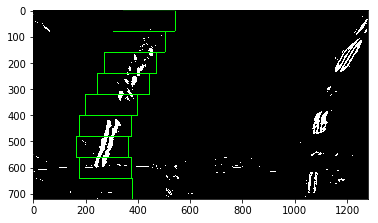

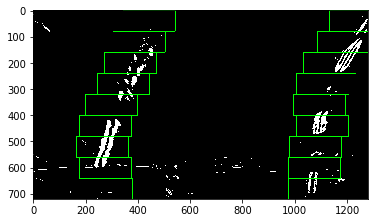

In [34]:
histogram = bottomHistogram(combined_binary)
left_center, right_center = getTwoPeaks(histogram)
nonzero = combined_binary.nonzero()
nonzero_y = np.array(nonzero[0])
nonzero_x = np.array(nonzero[1])
canvas = np.dstack((combined_binary, combined_binary, combined_binary)) * 255
left_lane_points = getLanePoints(canvas, nonzero_x, nonzero_y, left_center)
right_lane_points = getLanePoints(canvas, nonzero_x, nonzero_y, right_center)

In [35]:
def getFitLinePoints(x_points, y_points, fit_degree):
    line_coef = np.polyfit(y_points, x_points, fit_degree)
    y_steps = np.linspace(0, canvas.shape[0]-1, canvas.shape[0])
    x_fit = np.polyval(line_coef, y_steps)
    return x_fit, y_steps
    
def removeOutsidePoints(x_points, y_points, x_upper):
    pick = (0 <= x_points) & (x_points <= x_upper)
    y_points = y_points[pick]
    x_points = x_points[pick]
    return x_points, y_points

In [36]:
def drawFitLane(canvas, left_x_points, left_y_points, right_x_points, right_y_points, fit_degree):
    left_x_fit, left_y_steps = getFitLinePoints(left_x_points, left_y_points, fit_degree)
    left_x_fit, left_y_steps = removeOutsidePoints(left_x_fit, left_y_steps, canvas.shape[1])
    right_x_fit, right_y_steps = getFitLinePoints(right_x_points, right_y_points, fit_degree)
    right_x_fit, right_y_steps = removeOutsidePoints(right_x_fit, right_y_steps, canvas.shape[1])
        
    left_points = np.dstack((left_x_fit.astype(int), left_y_steps.astype(int))).reshape((-1, 1, 2))
    right_points = np.dstack((right_x_fit.astype(int), right_y_steps.astype(int))).reshape((-1, 1, 2))
    points = np.concatenate((left_points, right_points[::-1]))
    #pdb.set_trace()
    #canvas[y_steps.astype(int), x_fit.astype(int)] = (255, 0, 0)
    cv2.fillPoly(canvas, [points], (0, 255, 0))
    plt.figure(figsize=(16, 12))
    plt.imshow(canvas)

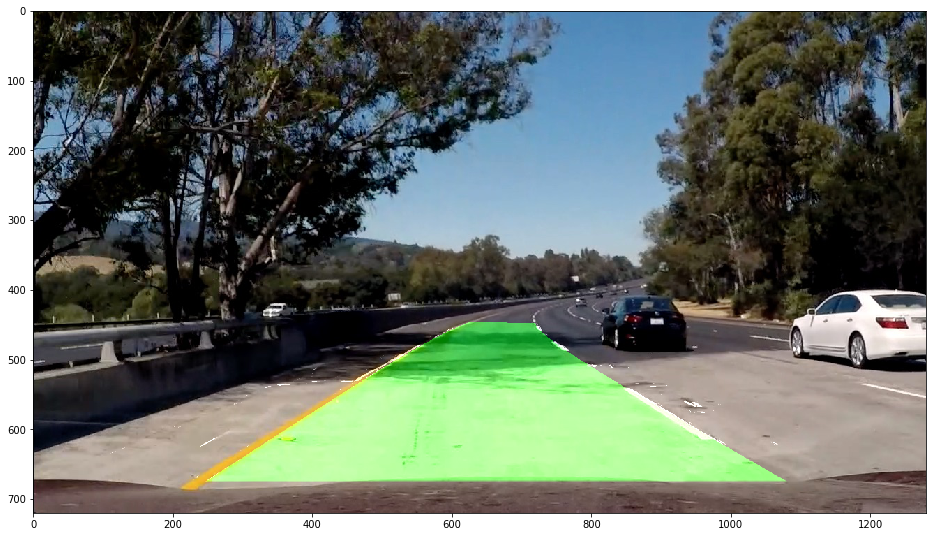

In [37]:
canvas = np.dstack((combined_binary, combined_binary, combined_binary)) * 255
drawFitLane(canvas, left_lane_points[0], left_lane_points[1], right_lane_points[0], right_lane_points[1], 2)
inv = cv2.warpPerspective(canvas, Minv, canvas.shape[1::-1])
res = cv2.addWeighted(inv, 0.5, straight_line_image, 1, 0)
plt.imshow(res)

[[[  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]]

 [[  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]]

 [[  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]]

 [[  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]]

 [[  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]]

 [[  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]
  [  0 250   0]]

 [[  0 250   0]
  [  0 250  

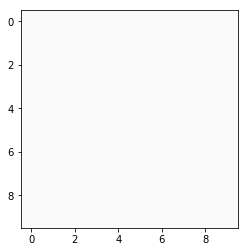

In [38]:
yellow = (250, 250, 250)
image = np.array([yellow for i in range(100)], dtype=np.uint8)
image.resize(10, 10, 3)
plt.imshow(image)
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
print(hsv)